<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Evaluation-of-TPC-H-Loading" data-toc-modified-id="Evaluation-of-TPC-H-Loading-1">Evaluation of TPC-H Loading</a></span><ul class="toc-item"><li><span><a href="#Import-some-libraries" data-toc-modified-id="Import-some-libraries-1.1">Import some libraries</a></span></li></ul></li><li><span><a href="#Load-Results" data-toc-modified-id="Load-Results-2">Load Results</a></span><ul class="toc-item"><li><span><a href="#Load-Results-and-Generate-Common-DataFrame" data-toc-modified-id="Load-Results-and-Generate-Common-DataFrame-2.1">Load Results and Generate Common DataFrame</a></span></li><li><span><a href="#Results-in-Format-&quot;time&quot;" data-toc-modified-id="Results-in-Format-&quot;time&quot;-2.2">Results in Format "time"</a></span></li><li><span><a href="#Results-in-Format-&quot;Throughput&quot;" data-toc-modified-id="Results-in-Format-&quot;Throughput&quot;-2.3">Results in Format "Throughput"</a></span></li></ul></li><li><span><a href="#Loading-Phase" data-toc-modified-id="Loading-Phase-3">Loading Phase</a></span><ul class="toc-item"><li><span><a href="#Plot-Throughput" data-toc-modified-id="Plot-Throughput-3.1">Plot Throughput</a></span></li><li><span><a href="#Plot-Time" data-toc-modified-id="Plot-Time-3.2">Plot Time</a></span></li><li><span><a href="#Plot-Variation" data-toc-modified-id="Plot-Variation-3.3">Plot Variation</a></span></li><li><span><a href="#Plot-Hardware-Metrics" data-toc-modified-id="Plot-Hardware-Metrics-3.4">Plot Hardware Metrics</a></span><ul class="toc-item"><li><span><a href="#SUT-loading" data-toc-modified-id="SUT-loading-3.4.1">SUT loading</a></span></li><li><span><a href="#Driver-loading" data-toc-modified-id="Driver-loading-3.4.2">Driver loading</a></span></li></ul></li></ul></li></ul></div>

# Evaluation of TPC-H Loading

<img src="https://raw.githubusercontent.com/Beuth-Erdelt/Benchmark-Experiment-Host-Manager/master/docs/workflow-sketch-simple.png"/>

## Import some libraries

In [1]:
from dbmsbenchmarker import *
import pandas as pd
pd.set_option("display.max_rows", None)
pd.set_option('display.max_colwidth', None)

# Some plotly figures
import plotly.graph_objects as go
import plotly.figure_factory as ff
import matplotlib.pyplot as plt

# Some nice output
from IPython.display import display, Markdown

import logging
logging.basicConfig(level=logging.INFO)


import re

def natural_sort(l): 
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key=alphanum_key)

In [2]:
# path of folder containing experiment results
resultfolder = "./"

# create evaluation object for result folder
evaluate = inspector.inspector(resultfolder)

# list of experiments to be combined
codes = [1686930610,1686933143,1686927300,1686936621,1686935854]

# Load Results

In [3]:
import ast
import json
import statistics
import pandas as pd

def generate_df(code):
    global SF, dbms, imported, portion_of_data
    path="./"
    with open(path+str(code)+"/connections.config",'r') as inf:
        connections = ast.literal_eval(inf.read())
    #print("found", len(connections), "connections")
    connections_sorted = sorted(connections, key=lambda c: c['name'])
    # loading
    evaluate.load_experiment(code)
    df = evaluate.get_loading_metrics('total_cpu_memory')
    df = df.T.max().sort_index()
    df = pd.DataFrame(df)
    hw_memory = df[0]
    df = evaluate.get_loading_metrics('total_cpu_util_s')
    df = df.T.max().sort_index() - df.T.min().sort_index()
    df = pd.DataFrame(df)
    hw_cpu = df[0]
    # benchmarking
    df = evaluate.get_streaming_metrics('total_cpu_memory')
    df = df.T.max().sort_index()
    df = pd.DataFrame(df)
    hw_memory_stream = df[0]
    df = evaluate.get_streaming_metrics('total_cpu_util_s')
    df = df.T.max().sort_index() - df.T.min().sort_index()
    df = pd.DataFrame(df)
    hw_cpu_stream = df[0]
    # data generator
    df = evaluate.get_datagenerator_metrics('total_cpu_memory')
    df = df.T.max().sort_index()
    df = pd.DataFrame(df)
    hw_memory_datagenerator = df[0]
    #print(hw_memory_datagenerator)
    df = evaluate.get_datagenerator_metrics('total_cpu_util_s')
    df = df.T.max().sort_index() - df.T.min().sort_index()
    df = pd.DataFrame(df)
    hw_cpu_datagenerator = df[0]
    # loader
    df = evaluate.get_loader_metrics('total_cpu_memory')
    df = df.T.max().sort_index()
    df = pd.DataFrame(df)
    hw_memory_loader = df[0]
    df = evaluate.get_loader_metrics('total_cpu_util_s')
    df = df.T.max().sort_index() - df.T.min().sort_index()
    df = pd.DataFrame(df)
    hw_cpu_loader = df[0]
    # benchmark
    df = evaluate.get_aggregated_experiment_statistics(type='timer', name='run', query_aggregate='Mean', total_aggregate='Mean')
    df_mean = (df/1000.0).sort_index()
    #print(df_mean)
    df = evaluate.get_aggregated_experiment_statistics(type='timer', name='run', query_aggregate='Median', total_aggregate='Geo')
    df_geo = (df/1000.0).sort_index()
    #print(df_geo)
    #df_metric[0]['PostgreSQL-BHT-1-1-1']
    #df_metric.plot()
    #pretty_connections = json.dumps(connections, indent=2)
    df_merged_time = pd.DataFrame()
    df_merged_tpx = pd.DataFrame()
    for c in connections_sorted:
        #print(c)
        connection_name = c['name']
        orig_name = c['orig_name']
        #print(connection_name, orig_name)
        properties = evaluate.get_experiment_connection_properties(connection_name)
        dbms = properties['docker']
        #print(properties)
        # load
        if orig_name in hw_cpu:
            hw_cpu_c = hw_cpu[orig_name]
        else:
            hw_cpu_c = 0
        if orig_name in hw_memory:
            hw_memory_c = hw_memory[orig_name]
        else:
            hw_memory_c = 0
        # stream
        if connection_name in hw_cpu_stream:
            hw_cpu_stream_c = hw_cpu_stream[connection_name]
        else:
            hw_cpu_stream_c = 0
        if connection_name in hw_memory_stream:
            hw_memory_stream_c = hw_memory_stream[connection_name]
        else:
            hw_memory_stream_c = 0
        # loader
        if orig_name in hw_cpu_loader:
            hw_cpu_loader_c = hw_cpu_loader[orig_name]
        else:
            hw_cpu_loader_c = 0
        if orig_name in hw_memory_loader:
            hw_memory_loader_c = hw_memory_loader[orig_name]
        else:
            hw_memory_loader_c = 0
        # data generator
        if orig_name in hw_cpu_datagenerator:
            hw_cpu_datagenerator_c = hw_cpu_datagenerator[orig_name]
        else:
            hw_cpu_datagenerator_c = 0
        if orig_name in hw_memory_datagenerator:
            hw_memory_datagenerator_c = hw_memory_datagenerator[orig_name]
        else:
            hw_memory_datagenerator_c = 0
        results = dict()
        eva = evaluate.get_experiment_connection_properties(c['name'])
        SF = int(c['parameter']['connection_parameter']['loading_parameters']['SF'])
        if 'TPCH_TABLE' in c['parameter']['connection_parameter']['loading_parameters']:
            TPCH_TABLE = c['parameter']['connection_parameter']['loading_parameters']['TPCH_TABLE']
        else:
            TPCH_TABLE = ''
        imported = TPCH_TABLE
        #if len(c['hostsystem']['loading_timespans']['sensor']) == 0:
        #    continue
        timespan_load = max([end for (start,end) in c['hostsystem']['loading_timespans']['sensor']]) - min([start for (start,end) in c['hostsystem']['loading_timespans']['sensor']])
        timespan_datagenerate = 0#max([end for (start,end) in c['hostsystem']['loading_timespans']['datagenerator']]) - min([start for (start,end) in c['hostsystem']['loading_timespans']['datagenerator']])
        timespan_benchmark = eva['times']['total'][c['name']]['time_end']-eva['times']['total'][c['name']]['time_start']
        results[connection_name] = {
            'load':eva['times']['load_ms']/1000.,
            'ingest':eva['times']['ingest_ms']/1000.,
            'generate':eva['times']['generate_ms']/1000.,
            'schema':eva['times']['schema_ms']/1000.,
            #'index':eva['times']['index_ms']/1000.,
            'loaded':eva['times']['script_times']['loaded'],
            'initschema':eva['times']['script_times']['initschema'],
            'span_load':timespan_load,
            'span_benchmark':timespan_benchmark,
            'mean_generate': 0,#statistics.mean([end-start for (start,end) in c['hostsystem']['loading_timespans']['datagenerator']]),
            'max_generate': 0,#max([end-start for (start,end) in c['hostsystem']['loading_timespans']['datagenerator']]),
            'min_generate': 0,#min([end-start for (start,end) in c['hostsystem']['loading_timespans']['datagenerator']]),
            'mean_load': statistics.mean([end-start for (start,end) in c['hostsystem']['loading_timespans']['sensor']]),
            'max_load': max([end-start for (start,end) in c['hostsystem']['loading_timespans']['sensor']]),
            'min_load': min([end-start for (start,end) in c['hostsystem']['loading_timespans']['sensor']]),
            'span_generate': timespan_datagenerate,#c['timeGenerate'],
            #'pods': int(c['parameter']['connection_parameter']['loading_parameters']['PODS_PARALLEL']),
            #'indexed':eva['times']['script_times']['indexed'],
            'initindexes':0,#eva['times']['script_times']['initindexes'],
            'initconstraints':0,#eva['times']['script_times']['initconstraints'],
            'initstatistics':0,#eva['times']['script_times']['initstatistics'],
            'benchmark_mean':df_mean.loc[connection_name]['total_timer_run'],
            'benchmark_geo':df_geo.loc[connection_name]['total_timer_run'],
        }
        # DataFrame of time
        df = pd.DataFrame(results).T
        df_time = df.copy()
        df_tpx = df.copy()
        # Compute DataFrame of throughput (Tpx)
        df_tpx = 3600*int(SF)/df_tpx * portion_of_data
        # Set Values that are same for time and tpx
        df_time['SF'] = int(SF)
        df_tpx['SF'] = int(SF)
        df_time['dbms'] = dbms
        df_tpx['dbms'] = dbms
        df_time['TPCH_TABLE'] = TPCH_TABLE
        df_tpx['TPCH_TABLE'] = TPCH_TABLE
        df_time['pods'] = int(c['parameter']['connection_parameter']['loading_parameters']['PODS_PARALLEL'])
        df_tpx['pods'] = int(c['parameter']['connection_parameter']['loading_parameters']['PODS_PARALLEL'])
        #df_time['threads'] = int(c['parameter']['connection_parameter']['loading_parameters']['MYSQL_LOADING_THREADS'])
        #df_tpx['threads'] = int(c['parameter']['connection_parameter']['loading_parameters']['MYSQL_LOADING_THREADS'])
        df_time['num_experiment'] = int(c['parameter']['numExperiment'])
        df_tpx['num_experiment'] = int(c['parameter']['numExperiment'])
        df_time['num_client'] = int(c['parameter']['client'])
        df_tpx['num_client'] = int(c['parameter']['client'])
        df_time['benchmark_start'] = eva['times']['total'][c['name']]['time_start']
        df_time['benchmark_end'] = eva['times']['total'][c['name']]['time_end']
        df_tpx['benchmark_start'] = eva['times']['total'][c['name']]['time_start']
        df_tpx['benchmark_end'] = eva['times']['total'][c['name']]['time_end']
        # load
        df_time['mem_max_load'] = hw_memory_c
        df_tpx['mem_max_load'] = hw_memory_c
        df_time['cpu_total_load'] = hw_cpu_c
        df_tpx['cpu_total_load'] = hw_cpu_c
        # stream
        df_time['mem_max_stream'] = hw_memory_stream_c
        df_tpx['mem_max_stream'] = hw_memory_stream_c
        df_time['cpu_total_stream'] = hw_cpu_stream_c
        df_tpx['cpu_total_stream'] = hw_cpu_stream_c
        # loader
        df_time['mem_max_loader'] = hw_memory_loader_c
        df_tpx['mem_max_loader'] = hw_memory_loader_c
        df_time['cpu_total_loader'] = hw_cpu_loader_c
        df_tpx['cpu_total_loader'] = hw_cpu_loader_c
        # data generator
        df_time['mem_max_datagenerator'] = hw_memory_datagenerator_c
        df_tpx['mem_max_datagenerator'] = hw_memory_datagenerator_c
        df_time['cpu_total_datagenerator'] = hw_cpu_datagenerator_c
        df_tpx['cpu_total_datagenerator'] = hw_cpu_datagenerator_c
        df_merged_time = pd.concat([df_merged_time, df_time])
        df_merged_tpx = pd.concat([df_merged_tpx, df_tpx])
    return df_merged_time, df_merged_tpx

def merge_experiments(df_time, df_tpx, code):
    df_time_tmp, df_tpx_tmp = generate_df(code)
    df_time = pd.concat([df_time, df_time_tmp])
    df_tpx = pd.concat([df_tpx, df_tpx_tmp])
    return df_time, df_tpx

## Load Results and Generate Common DataFrame

In [4]:
df_time = pd.DataFrame()
df_tpx = pd.DataFrame()

portion_of_data = 1.0 # for lineitem table = 0.7, for all tables = 1.0

for code in codes:
    df_time, df_tpx = merge_experiments(df_time, df_tpx, code)

Results in folder .//1686930610
Read results
Load Evaluation
Results in folder .//1686933143
Read results
Load Evaluation
Results in folder .//1686927300
Read results
Load Evaluation
Results in folder .//1686936621
Read results
Load Evaluation
Results in folder .//1686935854
Read results
Load Evaluation


## Results in Format "time"

In [5]:
df_time.T

,PostgreSQL-AWS-1-1-1,PostgreSQL-AWS-16-1-1,PostgreSQL-AWS-2-1-1,PostgreSQL-AWS-24-1-1,PostgreSQL-AWS-4-1-1,PostgreSQL-AWS-8-1-1,PostgreSQL-AWS-1-1-1,PostgreSQL-AWS-16-1-1,PostgreSQL-AWS-2-1-1,PostgreSQL-AWS-24-1-1,...,PostgreSQL-AWS-1-1-1,PostgreSQL-AWS-16-1-1,PostgreSQL-AWS-2-1-1,PostgreSQL-AWS-24-1-1,PostgreSQL-AWS-4-1-1,PostgreSQL-AWS-8-1-1,PostgreSQL-AWS-16-1-1,PostgreSQL-AWS-24-1-1,PostgreSQL-AWS-4-1-1,PostgreSQL-AWS-8-1-1
benchmark_geo,0.050316,0.047418,0.037656,0.048946,0.038176,0.052423,0.051277,0.126659,0.047242,0.04718,...,0.044375,0.05363,0.049937,0.047028,0.044508,0.041266,0.052453,0.041468,0.051875,0.051302
benchmark_mean,0.050316,0.047418,0.037656,0.048946,0.038176,0.052423,0.051277,0.126659,0.047242,0.04718,...,0.044375,0.05363,0.049937,0.047028,0.044508,0.041266,0.052453,0.041468,0.051875,0.051302
generate,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2533.0,1958.0
ingest,30.0,15.0,19.0,15.0,18.0,17.0,91.0,53.0,60.0,53.0,...,973.0,812.0,829.0,801.0,819.0,824.0,2391.0,2334.0,2296.0,2312.0
initconstraints,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
initindexes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
initschema,1.247854,1.120753,1.1774,1.16727,1.275027,1.165573,1.171618,1.130503,1.275446,1.202763,...,1.242657,1.156711,1.199116,0.974845,1.004594,1.269371,1.202668,1.192271,1.258674,1.244018
initstatistics,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
load,32.218995,17.056333,21.215824,17.242945,20.335081,19.210994,93.10821,55.188971,62.236146,55.247645,...,975.231061,814.134232,831.197372,802.966757,821.085932,826.344822,2393.147396,2336.170415,4834.375096,4274.3229
loaded,2.218995,2.056333,2.215824,2.242945,2.335081,2.210994,2.10821,2.188971,2.236146,2.247645,...,2.231061,2.134232,2.197372,1.966757,2.085932,2.344822,2.147396,2.170415,2.375096,2.3229


## Results in Format "Throughput"

In [6]:
df_tpx.T

,PostgreSQL-AWS-1-1-1,PostgreSQL-AWS-16-1-1,PostgreSQL-AWS-2-1-1,PostgreSQL-AWS-24-1-1,PostgreSQL-AWS-4-1-1,PostgreSQL-AWS-8-1-1,PostgreSQL-AWS-1-1-1,PostgreSQL-AWS-16-1-1,PostgreSQL-AWS-2-1-1,PostgreSQL-AWS-24-1-1,...,PostgreSQL-AWS-1-1-1,PostgreSQL-AWS-16-1-1,PostgreSQL-AWS-2-1-1,PostgreSQL-AWS-24-1-1,PostgreSQL-AWS-4-1-1,PostgreSQL-AWS-8-1-1,PostgreSQL-AWS-16-1-1,PostgreSQL-AWS-24-1-1,PostgreSQL-AWS-4-1-1,PostgreSQL-AWS-8-1-1
benchmark_geo,71547.16938,75921.141726,95602.672734,73549.753621,94300.375308,68672.494864,210619.172973,85268.273768,228610.652836,228911.103571,...,2433817.845287,2013785.893185,2162719.490222,2296489.511711,2426545.981636,2617157.669012,6863248.4033,8681445.638126,6939739.369678,7017304.477203
benchmark_mean,71547.16938,75921.141726,95602.672734,73549.753621,94300.375308,68672.494864,210619.172973,85268.273768,228610.652836,228911.103571,...,2433817.845287,2013785.893185,2162719.490222,2296489.511711,2426545.981636,2617157.669012,6863248.4033,8681445.638126,6939739.369678,7017304.477203
generate,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,142.123964,183.861083
ingest,120.0,240.0,189.473684,240.0,200.0,211.764706,118.681319,203.773585,180.0,203.773585,...,110.996917,133.004926,130.277443,134.831461,131.868132,131.067961,150.564617,154.241645,156.794425,155.709343
initconstraints,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
initindexes,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
initschema,2884.952626,3212.124726,3057.584004,3084.119049,2823.470243,3088.608505,9218.021881,9553.269566,8467.624281,8979.324417,...,86910.545921,93368.210748,90066.360369,110786.886674,107506.132727,85081.528716,299334.552368,301944.819551,286015.355224,289384.873981
initstatistics,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
load,111.735327,211.065303,169.684668,208.781042,177.033968,187.392696,115.994068,195.691275,173.532595,195.483445,...,110.742986,132.656257,129.933038,134.501209,131.533127,130.696045,150.429514,154.098347,74.466708,84.223866
loaded,1622.355749,1750.689563,1624.677959,1605.032733,1541.702708,1628.226743,5122.830401,4933.826052,4829.737654,4805.028969,...,48407.472286,50603.671487,49149.630435,54912.723265,51775.422332,46058.931707,167644.888715,165866.934096,151572.813293,154978.662809


# Loading Phase

## Plot Throughput

SF,1,3,10,30,100
pods,,,,,
1,120.000000,118.681319,100.000000,110.996917,NaN
2,200.000000,181.512605,148.453608,130.671506,NaN
4,225.000000,196.363636,155.675676,133.209991,160.302794
8,236.065574,214.392060,161.254199,133.086876,160.992789
16,316.483516,226.178010,167.393200,140.248356,158.120127
24,370.815451,225.391304,175.645456,152.461620,159.937802


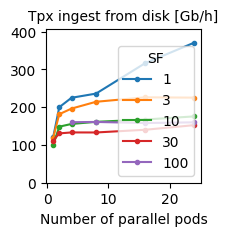

In [7]:
%matplotlib inline

df_tpx = df_tpx.astype({'pods':'int', 'mean_load': 'float'})

df_tpx_pivot = df_tpx.pivot(index='pods', columns='SF', values='mean_load')

df_tpx_pivot.plot(style='.-', title='PostgreSQL Tpx ingest from Disk [Gb/h]', figsize=(2,2))#, fontsize=14)#, logx=True)
plt.xlabel('Number of parallel pods')#, fontsize=14)
plt.ylim(0, df_tpx_pivot.max().max()*1.1)
plt.title("Tpx ingest from disk [Gb/h]".format(dbms=dbms, imported=imported), fontsize=10)

df_tpx_pivot

## Plot Time

SF,1,3,10,30,100
pods,,,,,
1,30.0,91.0,360.0,973.0,NaN
2,19.0,60.0,250.0,829.0,NaN
4,18.0,58.0,236.0,819.0,2296.0
8,17.0,55.0,232.0,824.0,2312.0
16,15.0,53.0,228.0,812.0,2391.0
24,15.0,53.0,225.0,801.0,2334.0


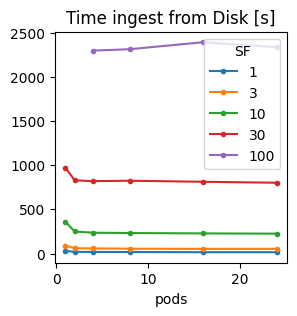

In [8]:
%matplotlib inline

df_time = df_time.astype({'pods':'int', 'span_load': 'float'})

df_time_pivot = df_time.pivot(index='pods', columns='SF', values='span_load')

df_time_pivot.plot(style='.-', title='Time ingest from Disk [s]'.format(SF=SF), figsize=(3,3))#, logx=True)

df_time_pivot

## Plot Variation

(0.0, 264.0)

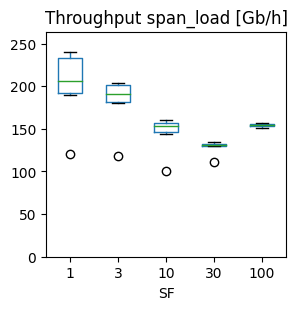

In [9]:
import matplotlib.pyplot as plt

column = 'span_load'
df_tpx.boxplot(column=column, by='SF', figsize=(3,3), grid=False)
plt.title('Throughput '+column+' [Gb/h]')
plt.suptitle('')
plt.ylim(0, df_tpx[column].max()*1.1)

## Plot Hardware Metrics

### SUT loading

In [10]:
df_res = pd.DataFrame()
for code in codes:
    evaluate.load_experiment(code)
    df = evaluate.get_loading_metrics('total_cpu_util_s').T.max() - evaluate.get_loading_metrics('total_cpu_util_s').T.min()
    df = df.reindex(index=natural_sort(df.index))
    path=resultfolder
    with open(path+str(code)+"/connections.config",'r') as inf:
        connections = ast.literal_eval(inf.read())
    #print("found", len(connections), "connections")
    connections_sorted = sorted(connections, key=lambda c: c['name'])
    SF = connections_sorted[0]['parameter']['connection_parameter']['loading_parameters']['SF']
    #print(df)
    df.index = df.index.map(lambda x: x[len('PostgreSQL-AWS-'):-2])
    #print(df)
    df_res[int(SF)] = df.copy()
    #df.T.max().plot.bar()

#print(df_res)

Results in folder .//1686930610
Read results
Load Evaluation
Results in folder .//1686933143
Read results
Load Evaluation
Results in folder .//1686927300
Read results
Load Evaluation
Results in folder .//1686936621
Read results
Load Evaluation
Results in folder .//1686935854
Read results
Load Evaluation


,1,3,10,30,100
DBMS,,,,,
1,22.837455,67.155406,230.774873,668.950694,NaN
2,23.004229,67.686138,224.245674,673.146856,NaN
4,23.542917,69.581872,230.473964,690.973398,2293.928170
8,24.414321,71.053594,235.386851,705.965703,2342.523498
16,25.491133,74.963579,246.195479,740.157869,2431.791202
24,28.815702,88.692082,289.329706,843.745166,2971.316369


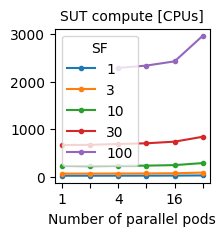

In [11]:
ax = df_res.plot(figsize=(2,2), grid=False, style=".-")
plt.title('SUT compute [CPUs]'.format(dbms), fontsize=10)
plt.suptitle('')
ax.set_xlabel("Number of parallel pods")
ax.set_xticks(range(0,6))
plt.legend(title='SF')
df_res

In [12]:
df_res = pd.DataFrame()
for code in codes:
    evaluate.load_experiment(code)
    df = evaluate.get_loading_metrics('total_cpu_memory').T.max()
    df = df.reindex(index=natural_sort(df.index))
    path=resultfolder
    with open(path+str(code)+"/connections.config",'r') as inf:
        connections = ast.literal_eval(inf.read())
    #print("found", len(connections), "connections")
    connections_sorted = sorted(connections, key=lambda c: c['name'])
    SF = connections_sorted[0]['parameter']['connection_parameter']['loading_parameters']['SF']
    #print(df)
    df.index = df.index.map(lambda x: x[len('PostgreSQL-AWS-'):-2])
    #print(df)
    df_res[SF] = df.copy()/1000#/int(SF)
    #df.T.max().plot.bar()

#print(df_res)

Results in folder .//1686930610
Read results
Load Evaluation
Results in folder .//1686933143
Read results
Load Evaluation
Results in folder .//1686927300
Read results
Load Evaluation
Results in folder .//1686936621
Read results
Load Evaluation
Results in folder .//1686935854
Read results
Load Evaluation


,1,3,10,30,100
DBMS,,,,,
1,2.468727,2.478484,2.513965,2.582262,NaN
2,2.544664,2.559020,2.596531,2.680793,NaN
4,2.642426,2.724898,2.758441,2.861277,3.091086
8,2.835707,2.967293,3.086348,3.183684,3.477621
16,3.051156,3.356426,3.747508,3.842277,4.179422
24,3.183504,3.724301,4.231504,4.517844,4.830570


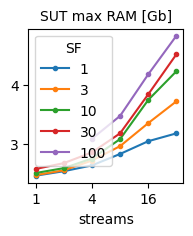

In [13]:
ax = df_res.plot(figsize=(2,2), grid=False, style=".-")
plt.title('SUT max RAM [Gb]'.format(dbms), fontsize=10)
plt.suptitle('')
ax.set_xlabel("streams")
#ax.set_xticks(range(1,11))
plt.legend(title='SF')
df_res

In [14]:
df_res = pd.DataFrame()
for code in codes:
    evaluate.load_experiment(code)
    df = evaluate.get_loading_metrics('total_cpu_memory_cached').T.max()
    df = df.reindex(index=natural_sort(df.index))
    path=resultfolder
    with open(path+str(code)+"/connections.config",'r') as inf:
        connections = ast.literal_eval(inf.read())
    #print("found", len(connections), "connections")
    connections_sorted = sorted(connections, key=lambda c: c['name'])
    SF = connections_sorted[0]['parameter']['connection_parameter']['loading_parameters']['SF']
    #print(df)
    df.index = df.index.map(lambda x: x[len('PostgreSQL-AWS-'):-2])
    #print(df)
    df_res[SF] = df.copy()/1000#/int(SF)
    #df.T.max().plot.bar()

#print(df_res)

Results in folder .//1686930610
Read results
Load Evaluation
Results in folder .//1686933143
Read results
Load Evaluation
Results in folder .//1686927300
Read results
Load Evaluation
Results in folder .//1686936621
Read results
Load Evaluation
Results in folder .//1686935854
Read results
Load Evaluation


,1,3,10,30,100
DBMS,,,,,
1,3.781121,6.351988,15.351352,41.037832,NaN
2,3.857188,6.432219,15.433789,41.137395,NaN
4,3.954691,6.594480,15.598148,41.330641,66.316094
8,4.147586,6.840926,15.921000,41.656012,66.324699
16,4.362391,7.228898,16.557793,42.301504,67.046434
24,4.494094,7.596902,17.035898,42.946730,66.238664


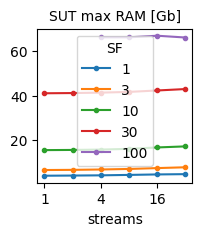

In [15]:
ax = df_res.plot(figsize=(2,2), grid=False, style=".-")
plt.title('SUT max RAM [Gb]'.format(dbms), fontsize=10)
plt.suptitle('')
ax.set_xlabel("streams")
#ax.set_xticks(range(1,11))
plt.legend(title='SF')
df_res

In [16]:
df_res = pd.DataFrame()
for code in codes:
    evaluate.load_experiment(code)
    df = evaluate.get_loading_metrics('total_cpu_util').T.max()
    df = df.reindex(index=natural_sort(df.index))
    path=resultfolder
    with open(path+str(code)+"/connections.config",'r') as inf:
        connections = ast.literal_eval(inf.read())
    #print("found", len(connections), "connections")
    connections_sorted = sorted(connections, key=lambda c: c['name'])
    SF = connections_sorted[0]['parameter']['connection_parameter']['loading_parameters']['SF']
    #print(df)
    df.index = df.index.map(lambda x: x[len('PostgreSQL-AWS-'):-2])
    #print(df)
    df_res[SF] = df.copy()
    #df.T.max().plot.bar()

#print(df_res)

Results in folder .//1686930610
Read results
Load Evaluation
Results in folder .//1686933143
Read results
Load Evaluation
Results in folder .//1686927300
Read results
Load Evaluation
Results in folder .//1686936621
Read results
Load Evaluation
Results in folder .//1686935854
Read results
Load Evaluation


,1,3,10,30,100
DBMS,,,,,
1,0.911616,0.916214,0.918942,0.928612,NaN
2,1.567085,1.517332,1.477990,1.473542,NaN
4,1.469309,1.516538,1.565692,1.538048,2.883220
8,1.562893,1.614310,1.462999,1.622547,2.884682
16,1.797822,1.515631,1.648837,1.780886,3.025232
24,1.201700,2.369155,2.243792,1.906653,3.888312


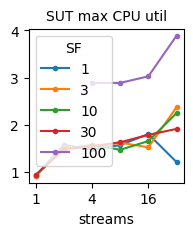

In [17]:
ax = df_res.plot(figsize=(2,2), grid=False, style=".-")
plt.title('SUT max CPU util'.format(dbms), fontsize=10)
plt.suptitle('')
ax.set_xlabel("streams")
#ax.set_xticks(range(1,11))
plt.legend(title='SF')
df_res

### Driver loading

In [18]:
df_res = pd.DataFrame()
for code in codes:
    evaluate.load_experiment(code)
    df = evaluate.get_loader_metrics('total_cpu_util_s').T.max() - evaluate.get_loader_metrics('total_cpu_util_s').T.min()
    df = df.reindex(index=natural_sort(df.index))
    path=resultfolder
    with open(path+str(code)+"/connections.config",'r') as inf:
        connections = ast.literal_eval(inf.read())
    #print("found", len(connections), "connections")
    connections_sorted = sorted(connections, key=lambda c: c['name'])
    SF = connections_sorted[0]['parameter']['connection_parameter']['loading_parameters']['SF']
    #print(df)
    df.index = df.index.map(lambda x: x[len('PostgreSQL-AWS-'):-2])
    #print(df)
    df_res[int(SF)] = df.copy()/int(SF)
    #df.T.max().plot.bar()

#print(df_res)

Results in folder .//1686930610
Read results
Load Evaluation
Results in folder .//1686933143
Read results
Load Evaluation
Results in folder .//1686927300
Read results
Load Evaluation
Results in folder .//1686936621
Read results
Load Evaluation
Results in folder .//1686935854
Read results
Load Evaluation


,1,3,10,30,100
DBMS,,,,,
1,1.818240,1.894317,1.908624,2.104277,NaN
2,1.317508,2.026014,1.992850,2.140043,NaN
4,2.050735,2.086456,2.138678,2.063723,2.201484
8,2.530665,2.482271,2.263641,2.120719,2.131740
16,2.743858,2.924177,2.508746,2.270688,2.101907
24,3.065573,3.446496,2.752613,2.041995,2.088980


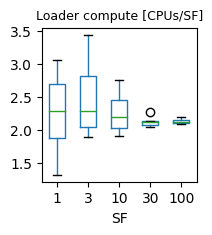

In [19]:
ax = df_res.boxplot(figsize=(2,2), grid=False)#, style=".-")
plt.title('Loader compute [CPUs/SF]'.format(dbms), fontsize=9)
plt.suptitle('')
ax.set_xlabel("SF")
#ax.set_xticks(range(0,8))
#plt.legend(title='SF')
df_res

In [20]:
df_res = pd.DataFrame()
for code in codes:
    evaluate.load_experiment(code)
    df = evaluate.get_loader_metrics('total_cpu_memory').T.max()
    df = df.reindex(index=natural_sort(df.index))
    path=resultfolder
    with open(path+str(code)+"/connections.config",'r') as inf:
        connections = ast.literal_eval(inf.read())
    #print("found", len(connections), "connections")
    connections_sorted = sorted(connections, key=lambda c: c['name'])
    SF = connections_sorted[0]['parameter']['connection_parameter']['loading_parameters']['SF']
    #print(df)
    df.index = df.index.map(lambda x: x[len('PostgreSQL-AWS-'):-2])
    #print(df)
    df_res[SF] = df.copy()/1000/int(SF)
    #df.T.max().plot.bar()

#print(df_res)

Results in folder .//1686930610
Read results
Load Evaluation
Results in folder .//1686933143
Read results
Load Evaluation
Results in folder .//1686927300
Read results
Load Evaluation
Results in folder .//1686936621
Read results
Load Evaluation
Results in folder .//1686935854
Read results
Load Evaluation


,1,3,10,30,100
DBMS,,,,,
1,0.812293,0.938633,1.032908,0.901002,NaN
2,0.518000,0.956458,1.031697,1.073972,NaN
4,0.743938,0.928936,1.029789,1.066697,1.083011
8,0.720375,0.956368,1.036818,1.061489,1.025637
16,0.459484,0.909536,1.034213,1.066820,1.019258
24,0.375516,0.917853,1.029581,0.911249,1.002379


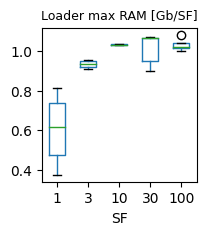

In [21]:
ax = df_res.boxplot(figsize=(2,2), grid=False)#, style=".-")
plt.title('Loader max RAM [Gb/SF]'.format(dbms), fontsize=9)
plt.suptitle('')
ax.set_xlabel("SF")
#ax.set_xticks(range(0,8))
#plt.legend(title='SF')
df_res